## Setup inicial


### Importação dos Pacotes

In [ ]:
# Import packages and initiate alias
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from math import sqrt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from matplotlib import pyplot
from pandas import Grouper


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split


### Conexão com o dados e pré-processamento dos dados

In [ ]:
# Connect with database
# local connection with spreadsheet
from google.colab import drive
drive.mount('/content/gdrive/')


## df: dataframe with data selected
csv=pd.read_csv('/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/air_traffic.csv')
print(csv.describe())

df=pd.DataFrame(csv);

print(df.columns)

# Change the variable to
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')

Mounted at /content/gdrive/
              Year       Month      Dom_LF      Int_LF          LF
count   249.000000  249.000000  249.000000  249.000000  249.000000
mean   2012.879518    6.445783   79.938394   77.304940   79.286305
std       6.002817    3.442803    8.860562   10.907145    8.895700
min    2003.000000    1.000000   13.090000   23.150000   13.830000
25%    2008.000000    3.000000   77.720000   76.430000   76.940000
50%    2013.000000    6.000000   82.120000   79.910000   81.580000
75%    2018.000000    9.000000   85.240000   82.930000   84.070000
max    2023.000000   12.000000   89.960000   89.440000   89.140000
Index(['Year', 'Month', 'Dom_Pax', 'Int_Pax', 'Pax', 'Dom_Flt', 'Int_Flt',
       'Flt', 'Dom_RPM', 'Int_RPM', 'RPM', 'Dom_ASM', 'Int_ASM', 'ASM',
       'Dom_LF', 'Int_LF', 'LF'],
      dtype='object')


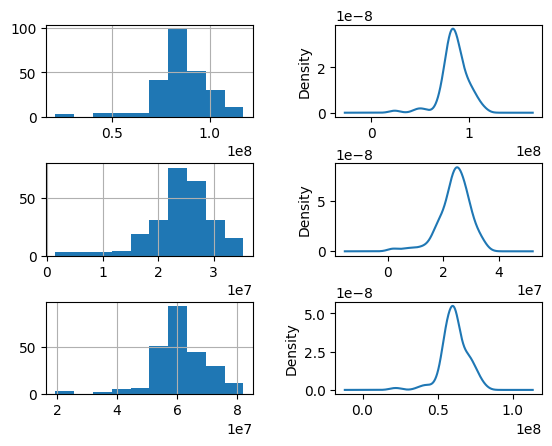

In [ ]:
#espaço entre os gráficos

# subplot(nrows, ncols, plot_number)
pyplot.figure(1)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
pyplot.subplot(321)
df['ASM'].hist()
pyplot.subplot(322)
df['ASM'].plot(kind='kde')
# pyplot.show()

# pyplot.figure(1)
pyplot.subplot(323)
df['Int_ASM'].hist()
pyplot.subplot(324)
df['Int_ASM'].plot(kind='kde')
# pyplot.show()

# pyplot.figure(1)
pyplot.subplot(325)
df['Dom_ASM'].hist()
pyplot.subplot(326)
df['Dom_ASM'].plot(kind='kde')
pyplot.show()

## Interpretação inicial dos dados

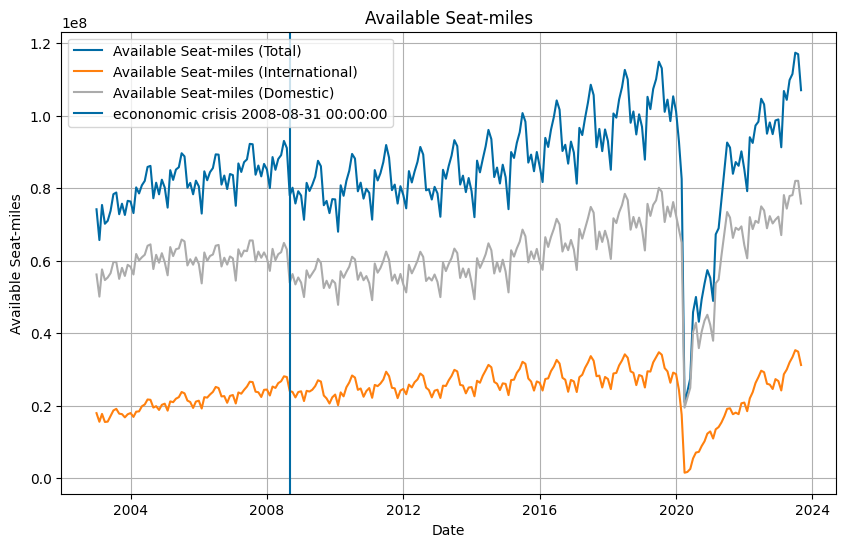

In [ ]:
#create a date column
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

#lockdown start date
lockdown_date = pd.Timestamp('2020-01-01')

plt.style.use('tableau-colorblind10')
#plot with matplotlib
plt.figure(figsize =(10,6))
plt.plot(df['date'],df['ASM'], label ='Available Seat-miles (Total)' )
plt.plot(df['date'],df['Int_ASM'], label ='Available Seat-miles (International)' )
plt.plot(df['date'],df['Dom_ASM'], label ='Available Seat-miles (Domestic)' )
# plt.axvline(lockdown_date, label = f'covid-19 lockdown {lockdown_date}')

period_01_final = pd.Timestamp('2008-08-31')
plt.axvline(period_01_final, label = f'econonomic crisis {period_01_final}')

plt.title('Available Seat-miles')
plt.xlabel('Date')
plt.ylabel('Available Seat-miles')
plt.grid(True)
plt.legend()
plt.savefig('/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/fig01_ASM.eps', format='eps')

# fig = plt.gcf()
plt.show()
# fig.savefig('./fig01_ASM', format='png')

Manipulando e extraindo plots de cada período

In [ ]:
def plotdf_periods(df, title ):
  plt.style.use('tableau-colorblind10')
  plt.figure(figsize =(10,6))
  plt.plot(df['date'],df['ASM'], label ='Available Seat-miles (Total)' )
  plt.plot(df['date'],df['Int_ASM'], label ='Available Seat-miles (International)' )
  plt.plot(df['date'],df['Dom_ASM'], label ='Available Seat-miles (Domestic)' )

  plt.title(f'Available Seat-miles {title}')
  plt.xlabel('Date')
  plt.ylabel('Available Seat-miles')
  plt.grid(True)
  plt.legend()
  plt.savefig(f'/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/fig{title}.eps', format='eps')

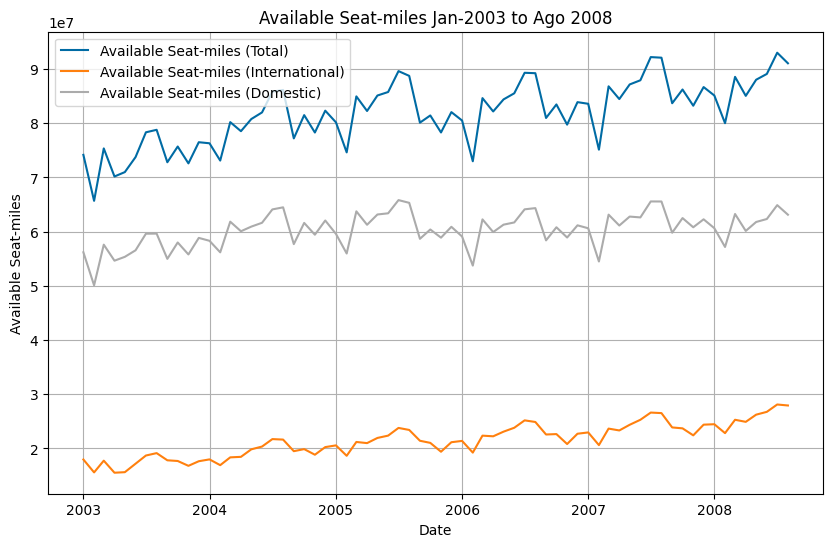

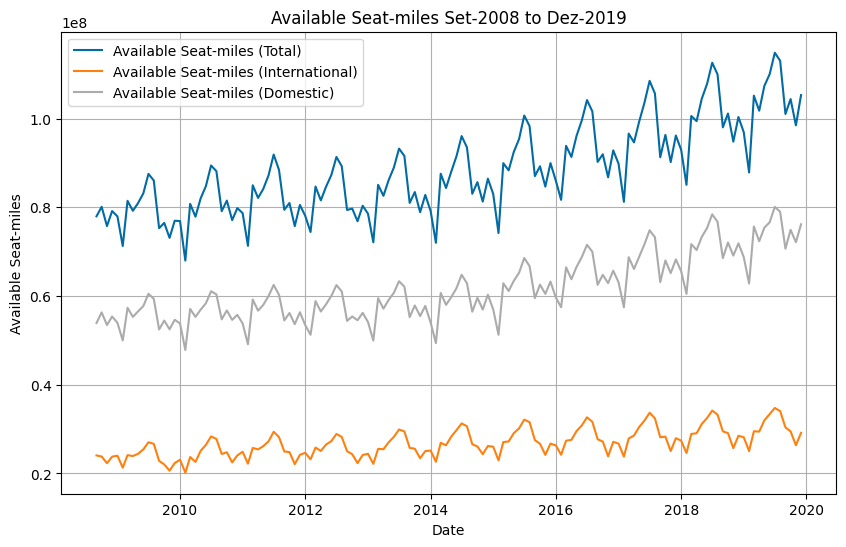

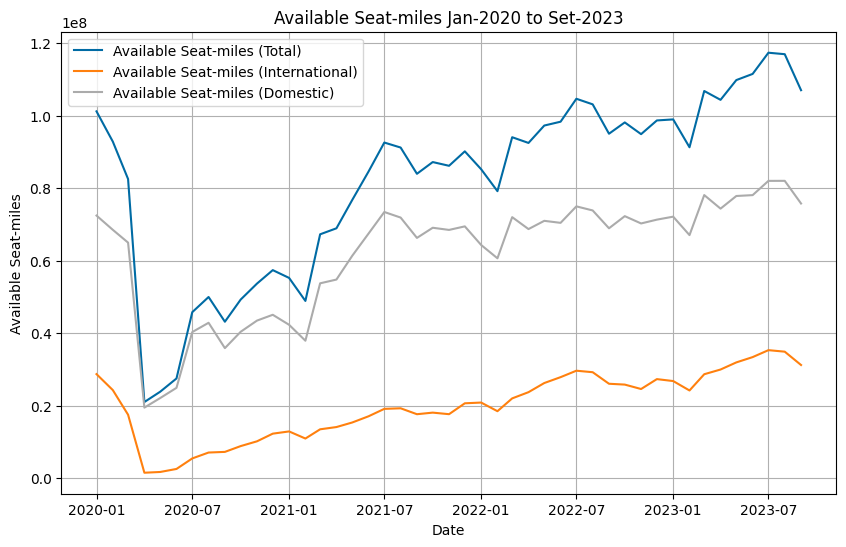

In [ ]:
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

period_01_final = pd.Timestamp('2008-08-31')
df_period_01 = df[df['date'] < period_01_final]
plotdf_periods(df_period_01, 'Jan-2003 to Ago 2008')

period_02_final = pd.Timestamp('2019-12-31')
df_period_02 = df[df['date'] > period_01_final]
df_period_02 = df_period_02[df_period_02['date'] < period_02_final]
plotdf_periods(df_period_02, 'Set-2008 to Dez-2019')

df_period_03 = df[df['date'] > period_02_final]
plotdf_periods(df_period_03, 'Jan-2020 to Set-2023')


## Modelo de regressão Linear

Iniciando pela separação entre
- treinamento(+validação)  
- teste


In [ ]:
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))                  #
period_02_final = pd.Timestamp('2019-12-31')

df['time'] = (df.index.values + 0.5) / 12

train_validation_df = df[df['date'] < period_02_final]                            # divisao do limiar entre o conjunto de treino
test_df = df[df['date'] > period_02_final]                                        # conjunto para teste

# convert date to numeric values
# X = train_validation_df.loc[:,['time']]
# y = train_validation_df.loc[:,['ASM']]

i = 24

dataframe = concat([train_validation_df['ASM'].shift(periods=i)])

list_col = []
for i in range(0, i):
  list_col.append(f't+{i}')

dataframe.columns = list_col

X = dataframe.values
# print(dataframe.values)

In [ ]:
## holdout de 70% e 30% no subconjunto de treinamento e validação
## Separação por holdout

# divide data into training and test data
train_size = int(len(X)*0.7)
test_size = len(X) - train_size

# train data 70 %
x_train, y_train = X[0:train_size], y[0:train_size]

# test data 30 %
x_test, y_test = X[train_size:], y[train_size:]


In [ ]:
def model_persistence(x):
  return x

In [ ]:
predictions = list()
for x in x_test:
  yhat = model_persistence(x)
  predictions.append(yhat)
rmse = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7095416.923


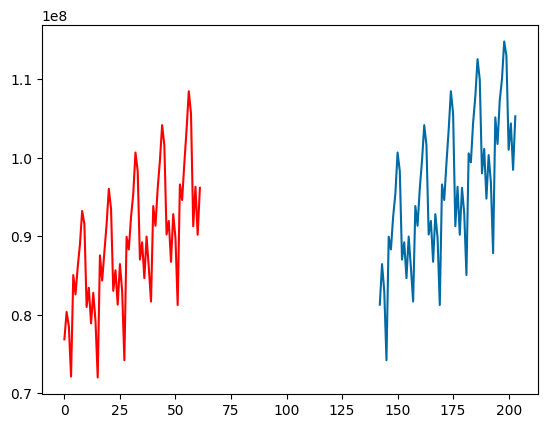

In [ ]:
pyplot.plot(y_test)
pyplot.plot(predictions, color='red')
pyplot.show()

## Resposta do item b1

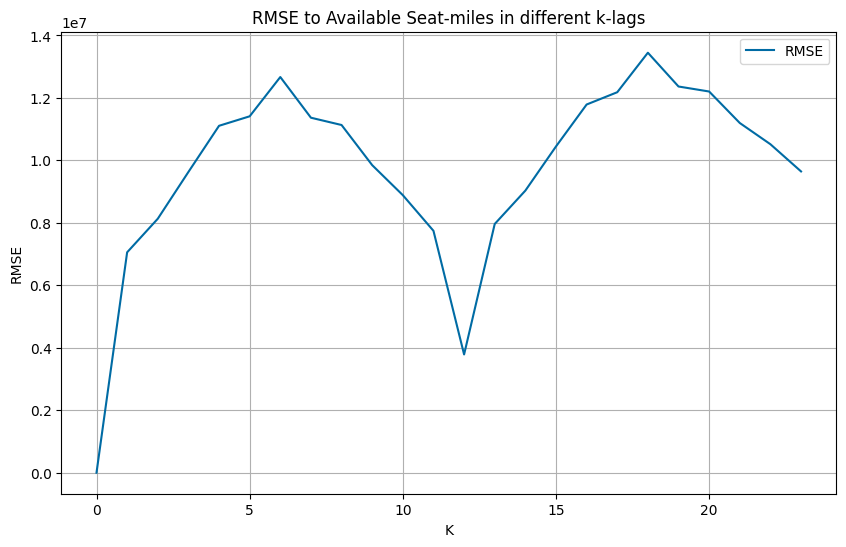

In [ ]:

k = 24
list_rmse = []
for i in range(k):
  dataframe = concat([train_validation_df['ASM'].shift(periods=i)])

  list_col = []
  for j in range(0, i):
    list_col.append(f't+{j}')

  dataframe.columns = list_col

  X = dataframe.values
  y = train_validation_df['ASM'].shift(periods=0)
  # print(dataframe.values)

  ## holdout de 70% e 30% no subconjunto de treinamento e validação
  ## Separação por holdout

  # divide data into training and test data
  train_size = int(len(X)*0.7)
  test_size = len(X) - train_size

  # train data 70 %
  x_train, y_train = X[0:train_size], y[0:train_size]

  # test data 30 %
  x_test, y_test = X[train_size:], y[train_size:]

  def model_persistence(x):
    return x


  predictions = list()
  for x in x_test:
    yhat = model_persistence(x)
    predictions.append(yhat)

  rmse = sqrt(mean_squared_error(y_test, predictions))
  list_rmse.append(rmse)

  # print('Test RMSE: %.3f' % rmse)

plt.style.use('tableau-colorblind10')
plt.figure(figsize =(10,6))
plt.plot(range(k), list_rmse, label ='RMSE' )

plt.title(f'RMSE to Available Seat-miles in different k-lags')

plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig('/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/fig_b1_rmse_1.eps', format='eps')

# pyplot.plot(predictions, color='red')
pyplot.show()

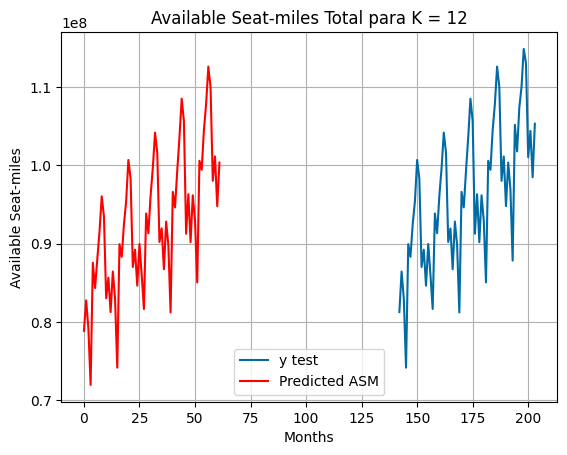

0.03774905051073754


In [ ]:
## Resposta do item b2

# k =
i = 12
# list_rmse = []
# for i in range(k):
dataframe2 = concat([train_validation_df['ASM'].shift(periods=i)])

list_col = []
for j in range(0, i):
  list_col.append(f't+{j}')

dataframe2.columns = list_col

X = dataframe2.values
y = train_validation_df['ASM'].shift(periods=0)
# print(dataframe.values)

## holdout de 70% e 30% no subconjunto de treinamento e validação
## Separação por holdout

# divide data into training and test data
train_size = int(len(X)*0.7)
test_size = len(X) - train_size

# train data 70 %
x_train, y_train = X[0:train_size], y[0:train_size]

# test data 30 %
x_test, y_test = X[train_size:], y[train_size:]

def model_persistence(x):
  return x


predictions = list()
for x in x_test:
  yhat = model_persistence(x)
  predictions.append(yhat)

# y_test.plot(kind='kde')
plt.grid(True)
plt.title(f'Available Seat-miles Total para K = 12')
plt.xlabel('Months')
plt.ylabel('Available Seat-miles')
pyplot.plot( y_test, label="y test")
pyplot.plot(predictions, color='red', label="Predicted ASM")
plt.legend()
plt.savefig('/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/fig_b2_k12.eps', format='eps')
pyplot.show()

# plt.xlabel('K')
# plt.ylabel('RMSE')


rmse = sqrt(mean_squared_error(y_test, predictions))
mape = mean_absolute_percentage_error(y_test, predictions )

print(mape)

## Resposta da questão c


In [ ]:
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))                  #
period_02_final = pd.Timestamp('2019-12-31')
period_03_final = pd.Timestamp('2021-12-31')
df['time'] = (df.index.values + 0.5) / 12

train_df = df[df['date'] < period_02_final]                                     # divisao do limiar entre o conjunto de treino
validation_df = df[df['date'] > period_02_final]                                # conjunto para teste
validation_df = validation_df[validation_df['date'] < period_03_final]          # conjunto para validação

test_df = df[df['date'] > period_03_final]                                      # conjunto para teste
# convert date to numeric values
# X = train_validation_df.loc[:,['time']]
# y = train_validation_df.loc[:,['ASM']]

In [ ]:

k = 24
list_rmse = []
for i in range(k):
  dataframe = concat([train_validation_df['ASM'].shift(periods=i)])

  list_col = []
  for j in range(0, i):
    list_col.append(f't+{j}')

  dataframe.columns = list_col

  X = dataframe.values
  y = train_validation_df['ASM'].shift(periods=0)
  # print(dataframe.values)

  ## holdout de 70% e 30% no subconjunto de treinamento e validação
  ## Separação por holdout

  # divide data into training and test data
  train_size = int(len(X)*0.7)
  test_size = len(X) - train_size

  # train data 70 %
  x_train, y_train = X[0:train_size], y[0:train_size]

  # test data 30 %
  x_test, y_test = X[train_size:], y[train_size:]

  def model_persistence(x):
    return x


  predictions = list()
  for x in x_test:
    yhat = model_persistence(x)
    predictions.append(yhat)

  rmse = sqrt(mean_squared_error(y_test, predictions))
  list_rmse.append(rmse)

  # print('Test RMSE: %.3f' % rmse)

plt.style.use('tableau-colorblind10')
plt.figure(figsize =(10,6))
plt.plot(range(k), list_rmse, label ='RMSE' )

plt.title(f'RMSE to Available Seat-miles in different k-lags')

plt.xlabel('K')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.savefig('/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/fig_b1_rmse_1.eps', format='eps')

# pyplot.plot(predictions, color='red')
pyplot.show()

In [ ]:
# walk-forward validation
# history = x
predictions = list()

for i in range(len(x_test)):
  # predict
  yhat = model_persistence(X)
  predictions.append(yhat)
  # observation
  obs = x_test[i]
  history.append(obs)
  print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))

# report performance
rmse = sqrt(mean_squared_error(x_test, predictions))
print('RMSE: %.3f' % rmse)

Test RMSE: 7095416.923
RMSE: 0.000


In [ ]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_train)

# results = model.evaluate(x_test, y_test)

mse = mean_squared_error(y_true=y, y_pred=y_pred, squared=True)
rmse = mean_squared_error(y_true=y, y_pred=y_pred, squared=False)

print('sklearn MSE: {:.6f}'.format(mse))
print('sklearn RMSE: {:.6f}'.format(rmse))


AttributeError: 'LinearRegression' object has no attribute 'evaluate'

In [ ]:
# !pip install latex
# !which xelatex
# !sudo apt-get install texlive-xetex

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

  # plt.plot(df['date'],df['ASM'], label ='Available Seat-miles (Total)' )
  # plt.plot(df['date'],df['Int_ASM'], label ='Available Seat-miles (International)' )
  # plt.plot(df['date'],df['Dom_ASM'], label ='Available Seat-miles (Domestic)' )
plt.title(f'Available Seat-miles')
plt.grid(True)
autocorrelation_plot(df['ASM'], label='Available Seat-miles (Total): 2003 - 2023')
autocorrelation_plot(train_validation_df['ASM'], label='Available Seat-miles (Total): 2003 - 2020')
plt.savefig(f'/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/autocorrelations_ASM_lag24.eps', format='eps')
pyplot.show()

pyplot.figure(2)
# subplot(nrows, ncols, plot_number)
# plt.subplots_adjust(wspace=0.4,hspace=0.5)
# pyplot.subplot(211)
plot_acf(df['ASM'], lags=24 )
plt.grid(True)
pyplot.show()

# pyplot.subplot(212)
plot_acf(train_validation_df['ASM'], lags=24 )
plt.grid(True)
plt.savefig(f'/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/autocorrelations_stats_model_ASM_lag24.eps', format='eps')
plt.savefig(f'/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/autocorrelations_stats_model_ASM_lag24.png', format='png')

plot_pacf(train_validation_df['ASM'], lags=24 )
plt.savefig(f'/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/partialautocorrelations_stats_model_ASM_lag24.eps', format='eps')
plt.savefig(f'/content/gdrive/MyDrive/Mestrado/ML-IA048-2024S1/T01/partialautocorrelations_stats_model_ASM_lag24.png', format='png')

plt.grid(True)
pyplot.show()

In [ ]:
# create lagged dataset
def create_lagged_dataset(k, values):
  list_df = []
  for i in range(k):
    list_df['i'] = values.shift(periods=i)

  dataframe = concat(list_values, axis=1)

  list_col = ['t']
  for i in range(0, k):
    list_col.append(f't+{i}')

  dataframe.columns = list_col
  dataframe = dataframe.fillna(0.0)

  print(dataframe.head(k))

  return dataframe

## Evaluate the linear model

In [ ]:
# Play an audio beep. Any audio URL will do.
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')